In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from scipy.signal import find_peaks
from typing import List

plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

In [7]:
def cargar_datos(file_name : str, pow_measure = False) -> List[np.ndarray]:
    
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de offset que alimentamos con el generador de funciones
    offs_values_keys = list(dic.keys())
    # Valores de corriente en mA
    corr_values = np.array([np.mean(dic[offset]["V_2"])*1000 for offset in offs_values_keys])
    # Varianza de la corriente
    corr_err_values = np.array([np.std(dic[offset]["V_2"])*1000 for offset in offs_values_keys])
    # Verdaderos valores de continua
    offs_true_values = np.array([np.mean(dic[offset]["V_1"]) for offset in offs_values_keys])
    # Le sacamos la "V" a las keys
    offs_values = np.array([float(offset[:-1]) for offset in offs_values_keys])

    # Creamos una lista para guardar todos los datos que nos interesan
    lista_mediciones = [offs_values, offs_true_values, corr_values, corr_err_values]

    # Mediciones de la potencia
    if pow_measure:
        POW_values = [np.mean(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW
        POW_var_values = [np.std(dic[offset]["POW"])*1000 for offset in offs_values_keys] # Potencia en mW

        lista_mediciones.append(POW_values)
        lista_mediciones.append(POW_var_values)

    return lista_mediciones

# Defino funciones para calcular ajustes lineales
def calc_delta(x: np.ndarray, y: np.ndarray) -> float:
    N = len(x)
    delta = N*sum(x**2)-(sum(x))**2
    return delta

def calc_a_1(x: np.ndarray,y: np.ndarray) -> float:
    delta = calc_delta(x,y)
    a_1 = (sum(x**2)*sum(y)-sum(x)*sum(x*y))/delta
    return a_1

def calc_a_2(x: np.ndarray, y: np.ndarray) -> float:
    delta = calc_delta(x,y)
    a_2 = (len(x)*sum(x*y)-sum(x)*sum(y))/delta
    return a_2

def calc_cov_matrix(x: np.ndarray, y: np.ndarray, sigma: float or np.ndarray) -> np.ndarray:
    delta = calc_delta(x,y)
    N = len(x) # Cant. de datos

    if type(sigma) == np.ndarray:
        
        var_a_1 = sum(sigma**2)*(sum(x**2)**2)+(sum(x)**2)*(sum((sigma*x)**2))-2*sum(x**2)*sum(x)*sum((sigma**2)*x)
        
        var_a_2 = (N**2)*sum((sigma*x)**2)+(sum(x)**2)*(sum(sigma**2))-2*N*sum(x)*sum((sigma**2)*x)
        
        cov_a_1_a_2 = sum((sigma**2)*x)*(N*sum(x**2)+(sum(x)**2))-sum(x)*(sum(x**2)*sum(sigma**2)+N*sum((x*sigma)**2))

        cov_matrix = (1/delta**2)*np.array([[var_a_1, cov_a_1_a_2],
                                           [cov_a_1_a_2, var_a_2]])
        
    else:
        cov_matrix = (sigma**2/delta)*np.array([[sum(x**2), -sum(x)],
                                                [-sum(x)   , N]])
    return cov_matrix

In [8]:
file_name = '../mediciones/D.D/Fuente de corriente/Barrido continua a 0 V de amp sobre R.pickle'

offs_values, offs_true_values, corr_values, corr_est_err = cargar_datos(file_name, pow_measure = False)

# Chequeo de relaciones entre los voltajes

In [41]:
def lineal(x, a, b): return a*np.array(x)+b

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(lineal, offs_values, offs_true_values)

# Imprimo en pantalla los valores de popt y pcov
a, b = popt
err_a, err_b = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'a: {a} ± {err_a}')
print(f'b: {b} ± {err_b}')

Los parametros de ajuste son:
a: 1.920941126314533 ± 0.014704238897938477
b: 0.03132405995631227 ± 0.027521525682941198


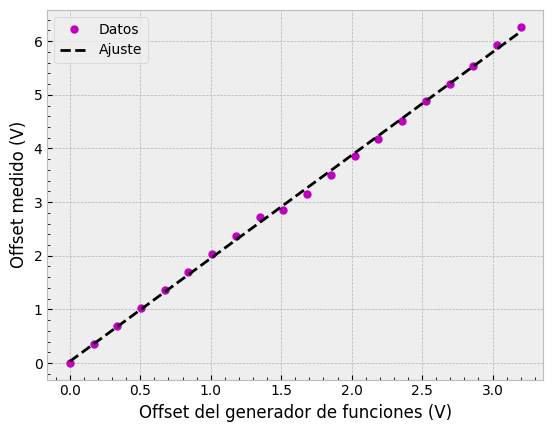

In [42]:
plt.plot(offs_values, offs_true_values, ".m",ms = 10, label = "Datos")
plt.plot(offs_values, lineal(np.array(offs_values),a,b), "--k", label = "Ajuste")
plt.xlabel("Offset del generador de funciones (V)")
plt.ylabel("Offset medido (V)")
plt.legend()
plt.show()

# Análisis de la fuente de corriente

In [11]:
corr_sist_err = np.abs(0.04*corr_values+ 3 + 0.1*50)
corr_err_values = np.sqrt(corr_sist_err**2+corr_est_err**2)

In [24]:
# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(lineal, offs_true_values, corr_values, sigma = corr_err_values)

# Imprimo en pantalla los valores de popt y pcov
a, b = popt
err_a, err_b = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'a: {a} ± {err_a}')
print(f'b: {b} ± {err_b}')

ajuste_lineal = lineal(offs_true_values,a,b)

Los parametros de ajuste son:
a: -71.53675471113037 ± 0.5216720339066834
b: 6.916649988375505 ± 1.90181830059293


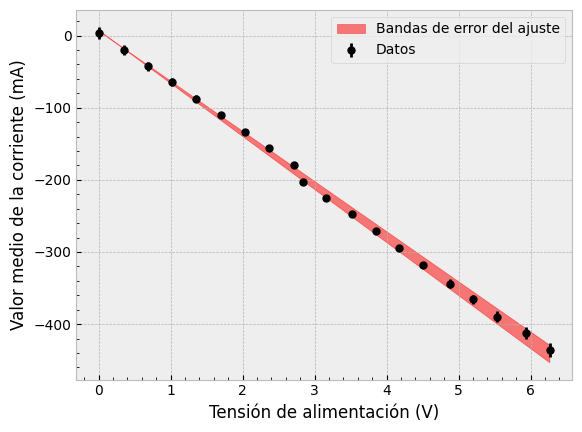

In [36]:
cov_matrix = pcov
sigma = np.sqrt(cov_matrix[1,1]+(offs_true_values**2)*cov_matrix[0,0]+2*offs_true_values*cov_matrix[0,1])
y_1 = ajuste_lineal+sigma
y_2 = ajuste_lineal-sigma

plt.fill(
    np.append(offs_true_values, offs_true_values[::-1]),
    np.append(y_1, y_2[::-1]),
    color = "r",
    alpha = 0.5,
    label = "Bandas de error del ajuste"
)

plt.errorbar(offs_true_values, corr_values, yerr = corr_err_values, fmt = ".k", ms = 10, label = "Datos")
#plt.plot(offs_true_values, ajuste_lineal,"--r", label = "Ajuste lineal" )
plt.ylabel("Valor medio de la corriente (mA)")
plt.xlabel("Tensión de alimentación (V)")
plt.legend()
plt.show()

In [27]:
resistance_rel = -a/1000
resistance_rel_err = err_a/1000

print(f"La relación entre las resistencias es {round(resistance_rel,4)} ± {round(resistance_rel_err, 4)} y debería ser {round(1/16,4)}")

La relación entre las resistencias es 0.0715 ± 0.0005 y debería ser 0.0625


In [19]:
chisquare(corr_values, ajuste_lineal)

Power_divergenceResult(statistic=-0.8170232547276044, pvalue=1.0)

Cosas a estudiar

In [ ]:
# Valor medio de respuesta vs. amplitud de alimentacion
# Valor medio de respuesta vs. offset de alimentacion
# Amplitud de respuesta vs. amplitud de alimentacion
# Amplitud de respuesta vs. offset de alimentacion
# frecuencia de respuesta vs. frecuencia de alimentacion

# Análisis de la fuente de corriente con cuadrados mínimos


In [12]:
corr_sist_err = np.abs(0.04*corr_values+ 3 + 0.1*50)
corr_err_values = np.sqrt(corr_sist_err**2+corr_est_err**2)

In [16]:
a_1, a_2 =calc_a_1(offs_true_values, corr_values), calc_a_2(offs_true_values, corr_values)

cov_matrix = calc_cov_matrix(offs_true_values, corr_values, corr_sist_err)

err_a_1, err_a_2 = np.sqrt(np.diag(cov_matrix))

print(f"a_1: {round(a_1,3)} ± {round(err_a_1,5)}")
print(f"a_2: {round(a_2,3)} ± {round(err_a_2,5)}")

a_1: 6.89 ± 2.74745
a_2: -71.466 ± 0.86891


In [17]:
resistance_rel = -a_2/1000
resistance_rel_err = err_a_2/1000

print(f"La relación entre las resistencias es {round(resistance_rel,4)} ± {round(resistance_rel_err, 4)} y debería ser {round(1/16,4)}")

La relación entre las resistencias es 0.0715 ± 0.0009 y debería ser 0.0625


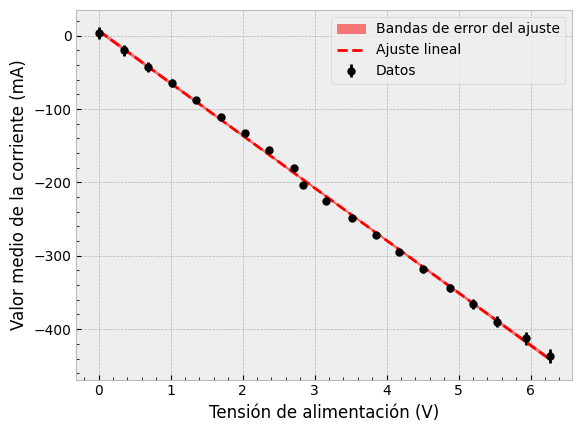

In [105]:
ajuste_lineal = lineal(offs_true_values, a_2, a_1)
sigma = np.sqrt(cov_matrix[0,0]+(offs_true_values**2)*cov_matrix[1,1]+2*offs_true_values*cov_matrix[0,1])
y_1 = ajuste_lineal+sigma
y_2 = ajuste_lineal-sigma

plt.fill(
    np.append(offs_true_values, offs_true_values[::-1]),
    np.append(y_1, y_2[::-1]),
    color = "r",
    alpha = 0.5,
    label = "Bandas de error del ajuste"
)

plt.errorbar(offs_true_values, corr_values, yerr = corr_err_values, fmt = ".k", ms = 10, label = "Datos")
plt.plot(offs_true_values, ajuste_lineal,"--r", label = "Ajuste lineal" )
plt.ylabel("Valor medio de la corriente (mA)")
plt.xlabel("Tensión de alimentación (V)")
plt.legend()
plt.show()

# Tiempo de respuesta de una cuadrada de 10 kHz

In [21]:
file_name = '../mediciones/D.D/Fuente de corriente/Tiempo respuesta fuente AMP0.5 FREQ10000 OFFS1 2.pickle'

# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

t_1,V_1,t_2,V_2 = [dic["1V"][key] for key in dic["1V"].keys()]

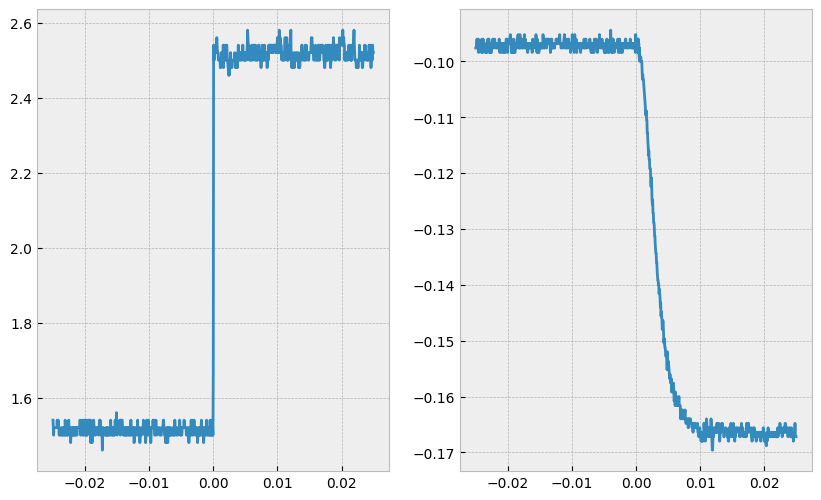

In [22]:
fig,axs = plt.subplots(ncols = 2, figsize = (10,6))

axs[0].plot(t_1[:],V_1[:])
axs[1].plot(t_2[:],V_2[:])
plt.show()

In [23]:
min(t_2),max(t_2)

(-0.024999999999999998, 0.02495)

In [24]:
new_t_2, new_V_2 = t_2[525:], V_2[525:]

In [26]:
# Ajuste exponencial
def exp(x, Amp, frec, y_0): return Amp*np.exp(-frec*np.array(x)) + y_0

# Utilizo curve_fit() para el ajuste
popt, pcov = curve_fit(exp, new_t_2, new_V_2, p0 = [1,400,-1], maxfev = 5000)

# Imprimo en pantalla los valores de popt y pcov
A, B, C = popt
err_A, err_B, err_C = np.sqrt(np.diag(pcov))
print("Los parametros de ajuste son:")
print(f'A: {A} ± {err_A}')
print(f'B: {B} ± {err_B}')
print(f'C: {C} ± {err_C}')


exponencial = exp(np.array(new_t_2),A,B,C)

Los parametros de ajuste son:
A: 0.11750776639861227 ± 0.001116083498568329
B: 434.23125617239873 ± 3.992681002783191
C: -0.1668971348588684 ± 7.782291760089922e-05


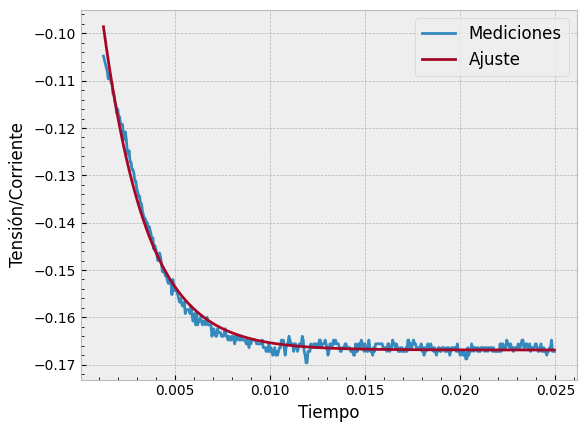

In [29]:
plt.plot(new_t_2,new_V_2,label = "Mediciones")
plt.plot(new_t_2,exponencial, label = "Ajuste")
plt.legend(fontsize = 12)
plt.xlabel("Tiempo")
plt.ylabel("Tensión/Corriente")
plt.show()

In [30]:
t_rta = 1/B
print(f"El tiempo de respuesta son {round(t_rta*1000,3)} ms")

El tiempo de respuesta son 2.303 ms


# Análisis de Fourier de la cuadrada de 10 kHz

In [31]:
file_name = '../mediciones/D.D/Cuadrada AMP1 FREQ10000 OFFS2.pickle'

# Cargamos los datos
with open(file_name, "rb") as f:
    dic = pickle.load(f)

t_1,V_1,t_2,V_2 = [dic["2V"][key] for key in dic["2V"].keys()]
t_1, t_2 = t_1/1000, t_2/1000 # Porque mide en milisegundos

In [32]:
def fourier(t: np.ndarray, v: np.ndarray) -> np.ndarray:

    # Le restamos el valor medio
    v = v-np.mean(v)

    transformada_0 = np.fft.fft(v)

    largo = len(t) # miro la cantidad de elementos que tiene el vector de ts
    d_t = np.mean(np.diff(t)) # miro los diferenciales de t entre mediciones
    frecuencia = np.fft.fftfreq(largo,d_t)
    frecuencia_max = 1/d_t # pregunta: ¿tiene sentido que la frecuencia máxima sea esta y no otra?
    # frecuencia = np.linspace(0, frecuencia_max, largo) # mi vector de frecuencias va de cero hasta la frecuencia máxima
    #y es del mismo largo que todos las demás
    transformada_a = np.abs(transformada_0) # le tomo el valor absoluto a la transformada,

    frecuencia = frecuencia[np.arange(largo//2)]
    transformada_a = transformada_a[np.arange(largo//2)]

    return frecuencia, transformada_a


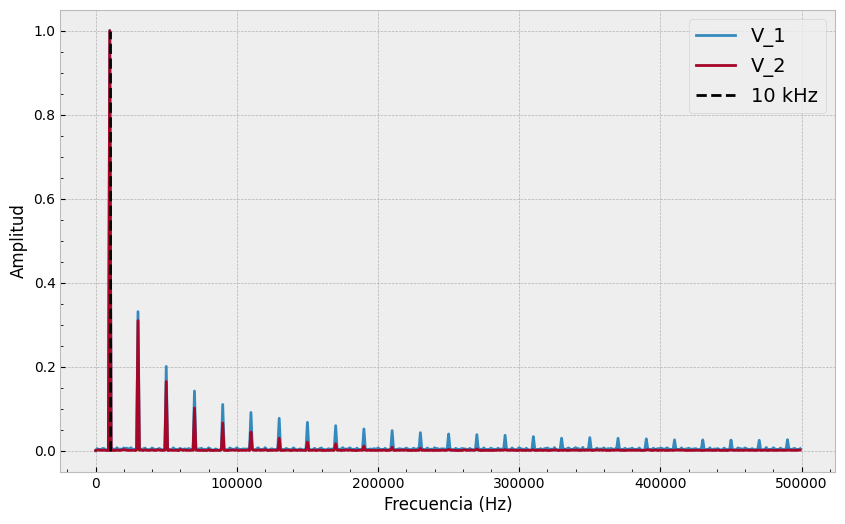

In [37]:
frec_1, tf_1 = fourier(t_1,V_1)
tf_1 = tf_1/max(tf_1)

frec_2, tf_2 = fourier(t_2,V_2)
tf_2 = tf_2/max(tf_2)

fig,ax = plt.subplots(figsize = (10,6))

ax.plot(frec_1, tf_1, label='V_1')
ax.plot(frec_2, tf_2, label='V_2')

ax.set_xlabel('Frecuencia (Hz)')
ax.set_ylabel('Amplitud')
ax.vlines(10000,ymin = 0,ymax= 1, ls = "--", color = "k", label = "10 kHz")
ax.legend(fontsize = 14)
plt.show()

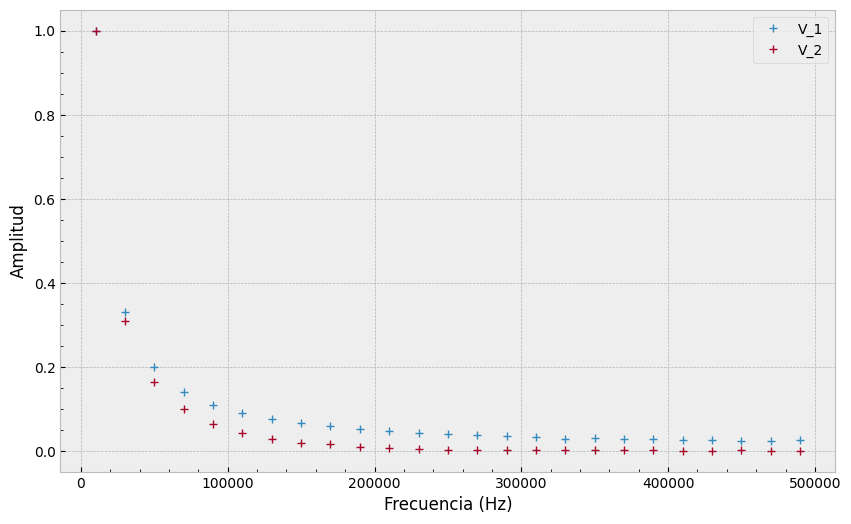

In [36]:
peaks_1, _ = find_peaks(tf_1, distance= 15)



peaks_2, _ = find_peaks(tf_2, distance= 15)

frec_peaks = frec_1[peaks_1]
tf_1_peaks = tf_1[peaks_1]
tf_2_peaks = tf_2[peaks_2]


plt.figure(figsize = (10,6))
plt.plot(frec_peaks,tf_1_peaks,"+", label = "V_1")
plt.plot(frec_peaks,tf_2_peaks,"+", label = "V_2")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

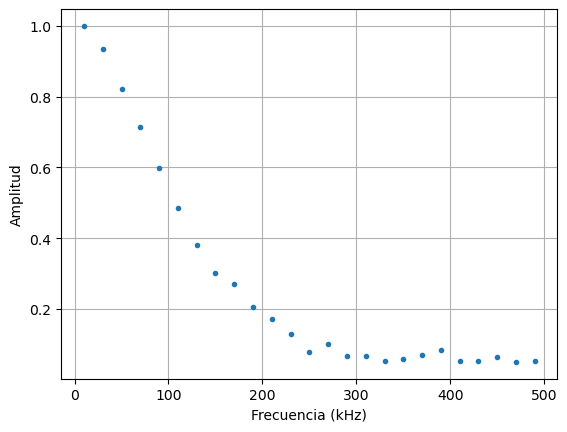

In [137]:
plt.plot(frec_peaks/1000, tf_2_peaks/tf_1_peaks, ".")
plt.xlabel("Frecuencia (kHz)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Barrido en amplitud

In [ ]:
volt = amp_values[-1]

condicion_maximo_1 = np.where(dic[volt]["V_1"]> np.mean(dic[volt]["V_1"]))
lista_maximos_1 = dic[volt]["V_1"][condicion_maximo_1]
tiempos_maximos_1 = dic[volt]["t_1"][condicion_maximo_1]

condicion_maximo_2 = np.where(dic[volt]["V_2"] > np.mean(dic[volt]["V_2"]))
lista_maximos_2 = dic[volt]["V_2"][condicion_maximo_2]
tiempos_maximos_2 = dic[volt]["t_2"][condicion_maximo_2]


condicion_minimo_2 = np.where(dic[volt]["V_2"] < np.mean(dic[volt]["V_2"]))
lista_minimos_2 = dic[volt]["V_2"][condicion_minimo_2]
tiempos_minimos_2 = dic[volt]["t_2"][condicion_minimo_2]

In [ ]:
t_1, v_1 = dic[volt]["t_1"], dic[volt]["V_1"]
t_2, v_2 = dic[volt]["t_2"], dic[volt]["V_2"]


fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
axs[1].axhline(np.mean(lista_maximos_2), ls = "--", c = "k")
axs[1].axhline(np.mean(lista_minimos_2), ls = "--", c = "k")

axs[0].plot(t_1,v_1, color = "b")
axs[0].set_xlabel("Tiempo (s)")
axs[1].plot(t_2,v_2, color = "orange")
axs[1].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Voltaje (V)")
axs[0].set_title("Canal 1")
axs[0].grid()
axs[1].set_title("Canal 2")
axs[1].grid()

plt.show()


In [ ]:
lista_amp_alim = []
lista_amp_corr = []

for amp in amp_values:
    
    # Calculamos la amplitud de la cuadrada con la que alimentamos
    condicion_maximo_1 = np.where(dic[amp]["V_1"]> np.mean(dic[amp]["V_1"]))
    lista_maximos_1 = dic[amp]["V_1"][condicion_maximo_1]
    tiempos_maximos_1 = dic[amp]["t_1"][condicion_maximo_1]
    
    condicion_minimo_1 = np.where(dic[amp]["V_1"] < np.mean(dic[amp]["V_1"]))
    lista_minimos_1 = dic[amp]["V_1"][condicion_minimo_1]
    tiempos_minimos_1 = dic[amp]["t_1"][condicion_minimo_1]
    
    # Calculamos la amplitud del generador de corriente
    condicion_maximo_2 = np.where(dic[amp]["V_2"] > np.mean(dic[amp]["V_2"]))
    lista_maximos_2 = dic[amp]["V_2"][condicion_maximo_2]
    tiempos_maximos_2 = dic[amp]["t_2"][condicion_maximo_2]

    condicion_minimo_2 = np.where(dic[amp]["V_2"] < np.mean(dic[amp]["V_2"]))
    lista_minimos_2 = dic[amp]["V_2"][condicion_minimo_2]
    tiempos_minimos_2 = dic[amp]["t_2"][condicion_minimo_2]
    
    amp_alim = np.mean(lista_maximos_1)-np.mean(lista_minimos_1)
    amp_corr = np.mean(lista_maximos_2)-np.mean(lista_minimos_2)
    
    lista_amp_alim.append(amp_alim) 
    lista_amp_corr.append(amp_corr*1000) # Lo pasamos a mA
    

In [ ]:
plt.plot(lista_amp_alim[:],lista_amp_corr[:],".", c = "b")
plt.xlabel("Amplitud de alimentación (V)")
plt.ylabel("Amplitud en corriente (mA)")
plt.grid()
plt.show()

In [ ]:
lista_corr_med = [np.mean(dic[amp]["V_2"]) for amp in amp_values]

plt.plot(lista_amp_alim[:-1],lista_corr_med[:-1],".", c = "b")
plt.title("Offset aprox 4.8 V", fontsize = 16)
plt.xlabel("Amplitud de alimentación (V)")
plt.ylabel("Amplitud en corriente (mA)")
plt.grid()
plt.show()

In [ ]:
# Cargamos los datos
with open(f"../mediciones/Barrido en amplitud a 2.4 V de offset.pickle", "rb") as f:
    dic = pickle.load(f)

In [ ]:
# Hago una lista con los valores de offset que alimentamos con el generador de funciones
amp_values = list(dic.keys())
print(offs_values)
# Valores de corriente en mA
corr_values = [np.mean(dic[amp]["V_2"])*1000 for amp in amp_values]
print(corr_values)

In [ ]:
amp_values_new = []
for amp in amp_values:
    new_amp = amp[:-1]
    amp_values_new.append(float(new_amp))

print("Valores del generador", amp_values_new)

In [ ]:
plt.plot(amp_values_new, amp_true_values, ".m",ms = 10, label = "Datos")
#plt.plot(amp_values_new, lineal(np.array(offs_values_new),a,b), "--k", label = "Ajuste")
plt.xlabel("Offset del generador de funciones (V)")
plt.ylabel("Offset medido (V)")
plt.legend()
plt.grid()
plt.show()